# **Prétraitement du texte**

Constitution des corpus, nettoyage, prétraitements en amont du BagOfWords

1. Corpus `product_name`
2. Corpus `product_category_tree`
3. Corpus `description`


Reste à faire :
1. Corpus `product_name`
    * Qualifier : ponctuation, stopword, etc : simplement ajouter des colonnes supplémentaires.
    * Il serait aussi intéressant de faire le 2D freq / len
2. Corpus `product_category_tree`
    * Ajouter un tri, d'abord par fréquence, puis par ordre lexico, du level 0 vers le 6
    * Il faut en plus sortir :
    1. le corpus des noms de catégories en tant que phrases
        * pour chacune, les niveaux dans lesquels elles apparaissent (en fréquence)
        * leur fréquence totale tous niveaux confondus
        * la longueur en mots
        * casefold
        * racinisation
        * lemmatisation
    2. tolenizer en mots et faire la même chose
3. Corpus `description`
    * découpage en phrases
    * découpage des phrases en mots
    * c'est laborieux...
    * Next step : chunking et chinking

# 1\. Corpus `product_name`

* Le nom d'un produit est une expression (une phrase unique sauf rares exceptions) de 2 à 30 mots.
* La plupart de ces expressions sont composées de 7 mots (avec un écart type de 3).

## Chargement des données

In [5]:
from flipkart_utils import get_raw_data, full_show_sample
corpus = get_raw_data('product_name')
full_show_sample(corpus, print_func=print)

('90e56526f4c5892beac49f262b85150a', "Mom and Kid Baby Girl's Printed Green Top & Pyjama Set")
('28401ff0dbc191d34c2f1103e78e082a', 'Frabjous Floral Single Quilts & Comforters Multicolor')
('6e7cc21610991cab64595af678e8eb5a', 'Tapawire Portable USB Flexible Stick Dimmable Touch Switch 10 Super Bright LED Reading Lamp B00 USB Led Light')
('da2ce8d17a17f9d19b368434aedea5e9', "Chokree Baby Girl's, Girl's A-line Dress")
('c417f408340252f170f05dadf88160d7', 'Arabian Nights Soex Cranberry Assorted Hookah Flavor')


## Longueur des phrases

Cette analyse permet notamment de déterminer un `clip` pertinent dans l'étape de pré-traitement.

,2,3,4,5,6,7,8,9,10,11,...,14,15,16,17,18,19,20,22,24,30
freq,36,13,105,122,128,159,154,108,81,36,...,14,15,3,3,2,3,1,1,1,1


mean: 7.55
med : 7.00
std : 3.11


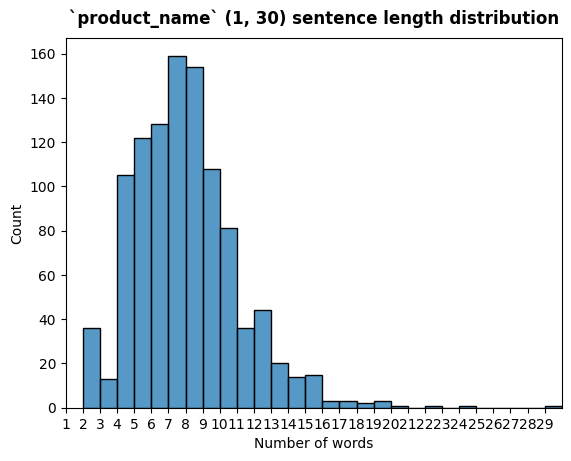

In [6]:
from flipkart_utils import get_raw_data
from tx_prep import (
    word_tokenize_corpus,
    lens, display_lens_dist, show_lens_dist
)
corpus = get_raw_data('product_name')
sent_lens = lens(word_tokenize_corpus(corpus))
display_lens_dist(sent_lens)
show_lens_dist(sent_lens, unit='word')

Les `product_name` de plus 15 mots sont des descriptions et slogans.

In [7]:
from flipkart_utils import full_show_sample
upper_outliers = corpus[sent_lens > 15]
full_show_sample(upper_outliers, n=10, print_func=print)

('63f2d92a3f5fc6cfc11e7f99d5798eac', 'Services Junction Beautiful Black and Golden color Diamond Ganesh idol for Pooja Showpiece  -  5 cm')
('85aec4bf3185da7ebcc45003429cbfe2', 'HP 15-ac116TX (Notebook) (Core i3 (5th Gen)/ 4GB/ 1TB/ Win10/ 2GB Graph) (N8M19PA)')
('bcb8e456728013a90ba66ab3b1b783ad', 'HP 15-ac121tu (Notebook) (Core i3 (5th Gen)/ 4GB/ 1TB/ Win10) (N8M17PA)')
('5e52d6ce133e5307814f9f3eedc5806d', 'posterchacha Ishita Personalised Custom Name Happy Birthday Gift Tea And Coffee  For Gift Use Ceramic Mug')
('7cdc62f8d3f7ab8b9d2dddc14c86de83', 'Akshaj Lightweight Flexible Portable Adjustable With 50000 Hours Life For Keyboard Laptop Pc Notebook Power Bank, Book Reading Work Bed USB Led Light')
('799ddb97164ff2d5d53bb8b27b8c355f', 'Indian Art Villa 2.3" X 6.9" X 2.3" Handmade High Quality Stainless Steel Copper Dish Serving Indian Food Daal Curry Karahi Kadai Wok Bowl Kadhai 0.7 L')
('cf3e938bf6d66c65ce94f8c206ed0809', 'e.l.f. Cosmetics Studio brow Kit Ash Brow Makeup Brush Mirr

Les noms de produits de 2 mots sont pour l'essentiel un couple *marque* (`brand`) et *référence produit* (un code alphanumérique).

In [8]:
from flipkart_utils import full_show_sample
lower_outliers = corpus[sent_lens < 3]
full_show_sample(lower_outliers, n=10, print_func=print)

('1eda39f01d0a8a2e5ce4b32fc7da1027', 'iBall wr7011a')
('26989e846c2096a5b59b59cbea2cc7ab', 'Tenda A6')
('17611e6e94d73ef376834e5c6ee03dde', 'TRUE Bong')
('0b852704f2002f8865a68818ad4951da', 'Ocean CPGW087')
('b1c7aa8e0f50e7ee73ed30d12af1a961', 'Airtel B310s-927')
('e33795f66b2a42ac56095ae704ab25b6', 'AntiqueShop ABKL_PL_PNK_PNK')
('7fd12776e6d62da6e1dd3cbc9882ee5f', 'Asus DSL-N10_C1')
('aa82b75da7579007963e53b6f818281b', 'AntiqueShop ABKL_GRN_GRN_GRN')
('9a993e1b59649c93f667d38227325066', 'Edimax AR-7286WNA')
('4fe24e100a5fcc33cf6054ef101067ed', 'TP-LINK TD-W8970')


## Formation du lexique

Nous constuisons le lexique des mots employés dans les noms des produits ($2\,525$ mots).

On compare au passage le `split` natif avec `word_tokenize` pour avoir un bref aperçu de l'avantage du second par rapport au premier.

Il s'agit d'une version brute. La version que nous allons sauvegarder, un peu plus bas, aura passé un ensemble d'étapes de filtrage et de normalisation.

In [7]:
from flipkart_utils import get_raw_data
from tx_prep import get_lexicon_dict
raw_product_names = get_raw_data('product_name')
naive_lexicon = get_lexicon_dict(raw_product_names, lambda x: x.split())
nltk_lexicon = get_lexicon_dict(raw_product_names)
print('Naive lexicon size :', len(naive_lexicon))
print('NLTK lexicon size :', len(nltk_lexicon))
not_in_nltk_lexicon = [k for k in naive_lexicon if k not in nltk_lexicon]
not_in_naive_lexicon = [k for k in nltk_lexicon if k not in naive_lexicon]
print(f"not in nltk lexicon ({len(not_in_nltk_lexicon)})", not_in_nltk_lexicon)
print(f"not in naive lexicon ({len(not_in_naive_lexicon)})", not_in_naive_lexicon)
display(list(nltk_lexicon.items())[:5])

Naive lexicon size : 2550
NLTK lexicon size : 2525
not in nltk lexicon (107) ['Men,', 'Boys,', 'Women,', 'Girls,', "Girl's", "Kripa's", 'Blue,', 'Liner,', 'Gloss,', 'PROTECTOR(SET', '2)', '(Set', "Boy's", '@home', 'K&P', "Boy's,", '(Carved', 'Hematite)', 'UNIT-125PROG.', 'Day:', "We're", "I'm", 'Mom.', "What'S", 'Superpower?', 'Heart,', '4"-', 'Fine-Finish)', 'Queen.', '2.3"', '6.9"', "Mamma'S", 'Fire,', 'RO,Black', 'Sport,Hamilton', "Layer'r", ',Explode', '(Pack', '3)', ',Orignal', '(N)', ',Four', 'Caliber,Pride', 'Charge,Surge', 'Rio,Hawaii', 'Intense,Magnetic', 'Dynamic,Magnetic', 'Drift,Wave', 'Brave,Caliber', 'Cool,Honour', 'RO,Spring', 'Brown,', "Girl's,", 'Yellow,', 'Grey,', '(Co2', 'Extract)', 'Black,', 'N1536(GW)_1', 'Computers,', 'Laptops,', 'Aloe,', 'Maple,', 'Arecaceae,', 'Palm,', 'R&Mshoppee', '(Notebook)', '(Core', '(5th', 'Gen)/', 'Graph)', '(N8M19PA)', 'Win10)', '(N8M17PA)', "Women's", 'Wow!', 'White,', 'Top,', 'Towel,', 'W,', 'Abstract,', 'Polka,', 'Geometric,', "Radhi

[('Elegance', 2),
 ('Polyester', 21),
 ('Multicolor', 29),
 ('Abstract', 37),
 ('Eyelet', 19)]

Le lexique se présente comme un dictionnaire avec les mots pour clé et leur fréquence d'emploi pour valeur.

Un DataFrame sera plus pratique pour manipuler ces données de lexique, et les enrichir d'autres caractéristiques que la seule fréquence d'emploi :

In [8]:
from flipkart_utils import get_raw_data
from tx_prep import get_lexicon_dataframe
product_names = get_raw_data('product_name')
lex_data = get_lexicon_dataframe(product_names)
display(lex_data)

,word,freq,len
product_name,,,
0,Elegance,2,8
1,Polyester,21,9
2,Multicolor,29,10
3,Abstract,37,8
4,Eyelet,19,6
...,...,...,...
2520,Uberlyfe,2,8
2521,Pigmented,1,9
2522,Polyvinyl,1,9


## Longueur et fréquence des mots

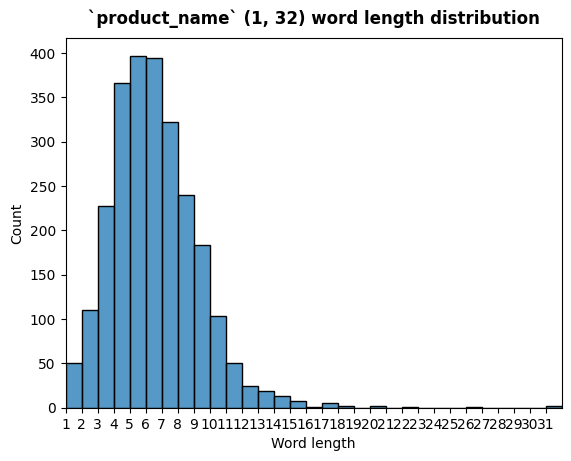

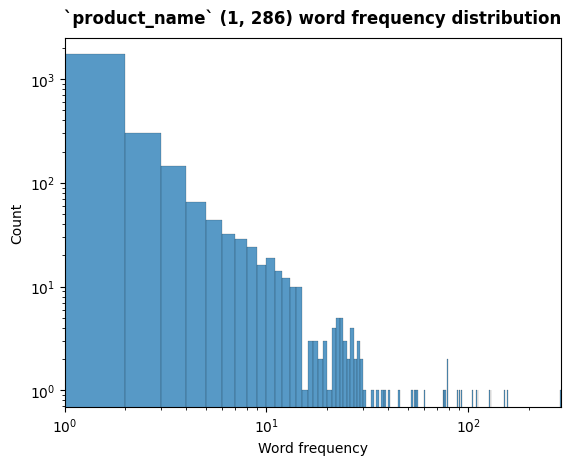

In [9]:
from tx_prep import show_lexicon_dist
show_lexicon_dist(lex_data, 'len')
show_lexicon_dist(lex_data, 'freq')

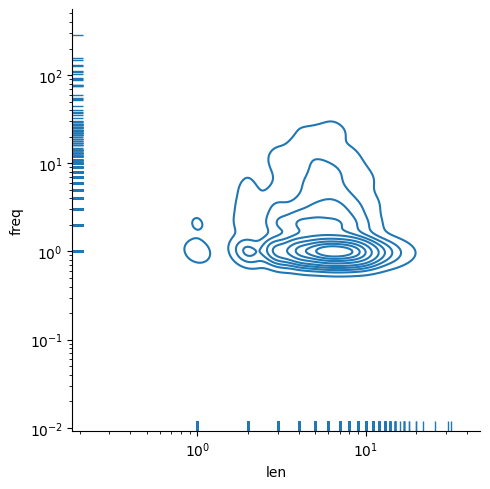

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(lex_data, x='len', y='freq', kind='kde', rug=True, log_scale=True)
plt.show()

## Normalisation de la casse

On préfère `casefold` à `lower` car celle-ci est mieux internationalisée que la second taillée sur mesure pour l'anglais.

In [20]:
from tx_prep import get_casefolded_lexicon_dataframe
import pandas as pd
s = pd.Series(['The quick brown fox', 'jumps over', 'the lazy dog'])
get_casefolded_lexicon_dataframe(s)

,word,forms,freq,len
0,dog,dog,1,3
1,fox,fox,1,3
2,the,"[The, the]",2,3
3,lazy,lazy,1,4
4,over,over,1,4
5,brown,brown,1,5
6,jumps,jumps,1,5
7,quick,quick,1,5


In [11]:
casefolded_words = lex_data.word.str.casefold()
print('casefolded nunique:', casefolded_words.nunique())
lex_data['casefolded_word'] = casefolded_words
lex_data.sort_values(by=['len', 'freq'], inplace=True)
display(lex_data)

casefolded nunique: 2398


,word,freq,len,casefolded_word
product_name,,,,
38,T,1,1,t
161,s,1,1,s
268,G,1,1,g
428,K,1,1,k
429,P,1,1,p
...,...,...,...,...
847,Ruchikainternational,2,20,ruchikainternational
2243,m_jug015-1-prishaindia,1,22,m_jug015-1-prishaindia
63,Megnet_Led_Sport_BlackRed1,1,26,megnet_led_sport_blackred1


La réduction de la casse nous permet d'éliminer quelques doublons modulo la casse.

Cela réduit le lexique à 2398 termes, soit un gain de 127.

In [12]:
counts = lex_data.casefolded_word.value_counts()
display(counts[counts > 1])

multi       3
fashion     3
gift        3
for         3
set         3
           ..
n           2
pc-122      2
g           2
s           2
fastrack    2
Name: casefolded_word, Length: 116, dtype: int64

In [13]:
def first(x):
    return x.values[0]

def scalar_or_list(x):
    return first(x) if len(x) == 1 else x


gpby = lex_data.groupby(by='casefolded_word').agg({
    'word': scalar_or_list,
    'freq': sum,
    'len': first
})

gpby.columns = ['forms', 'freq', 'len']
gpby.sort_values(by=['len', 'freq'], inplace=True)
display(gpby)

,forms,freq,len
casefolded_word,,,
%,%,1,1
',',1,1
+,+,1,1
:,:,1,1
b,B,1,1
...,...,...,...
ruchikainternational,Ruchikainternational,2,20
m_jug015-1-prishaindia,m_jug015-1-prishaindia,1,22
megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,1,26


Cette fonction réalise la chaîne précédente :

In [14]:
from flipkart_utils import get_raw_data
from tx_prep import get_casefolded_lexicon_dataframe
product_names = get_raw_data('product_name')
lex_data = get_casefolded_lexicon_dataframe(product_names)
display(lex_data)

,word,forms,freq,len
0,%,%,1,1
1,',',1,1
2,+,+,1,1
3,:,:,1,1
4,b,B,1,1
...,...,...,...,...
2393,ruchikainternational,Ruchikainternational,2,20
2394,m_jug015-1-prishaindia,m_jug015-1-prishaindia,1,22
2395,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,1,26
2396,painting_art_couple_love__dance,painting_art_couple_love__Dance,1,31


## Stopwords

In [15]:
from tx_prep import is_stopword_en
is_stopword = is_stopword_en(lex_data.word)
print('# stopwords:', is_stopword.sum())
lex_data['is_stopword_en'] = is_stopword
display(lex_data[lex_data.is_stopword_en].tail())

# stopwords: 41


,word,forms,freq,len,is_stopword_en
613,your,Your,2,4,True
685,with,"[With, with]",47,4,True
975,under,Under,2,5,True
1174,having,Having,1,6,True
1932,yourself,Yourself,1,8,True


## Lemmatisation et stemmatisation

Réduction des mots à leur racine indépendamment de leur flexion.

Les regroupements permettent de gagner :
* Par la stemmatisation, 94 mots.
* Par la lemmatisation, 50 mots.

Dans le cadre de la réduction du lexique, nous prenons la racine (stem) comme pivot.

### Stemmatisation

In [16]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
lex_data['stem'] = lex_data.word.apply(lambda x: stemmer.stem(x))
display(lex_data)
display(lex_data.stem.value_counts())

,word,forms,freq,len,is_stopword_en,stem
0,%,%,1,1,False,%
1,',',1,1,False,'
2,+,+,1,1,False,+
3,:,:,1,1,False,:
4,b,B,1,1,False,b
...,...,...,...,...,...,...
2393,ruchikainternational,Ruchikainternational,2,20,False,ruchikaintern
2394,m_jug015-1-prishaindia,m_jug015-1-prishaindia,1,22,False,m_jug015-1-prishaindia
2395,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,1,26,False,megnet_led_sport_blackred1
2396,painting_art_couple_love__dance,painting_art_couple_love__Dance,1,31,False,painting_art_couple_love__d


color                            4
decor                            4
shape                            3
beauti                           3
design                           3
                                ..
grass                            1
graph                            1
graco                            1
gopal                            1
good-night-angel-sleep-well-p    1
Name: stem, Length: 2304, dtype: int64

### Lemmatisation

In [17]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lex_data['lem'] = lex_data.word.apply(lambda x: lemmatizer.lemmatize(x))
display(lex_data)
display(lex_data.lem.value_counts())

,word,forms,freq,len,is_stopword_en,stem,lem
0,%,%,1,1,False,%,%
1,',',1,1,False,','
2,+,+,1,1,False,+,+
3,:,:,1,1,False,:,:
4,b,B,1,1,False,b,b
...,...,...,...,...,...,...,...
2393,ruchikainternational,Ruchikainternational,2,20,False,ruchikaintern,ruchikainternational
2394,m_jug015-1-prishaindia,m_jug015-1-prishaindia,1,22,False,m_jug015-1-prishaindia,m_jug015-1-prishaindia
2395,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,1,26,False,megnet_led_sport_blackred1,megnet_led_sport_blackred1
2396,painting_art_couple_love__dance,painting_art_couple_love__Dance,1,31,False,painting_art_couple_love__d,painting_art_couple_love__dance


time                                2
sticker                             2
natural                             2
statue                              2
abstract                            2
                                   ..
kesar                               1
klein                               1
klocx                               1
kokum                               1
good-night-angel-sleep-well-pics    1
Name: lem, Length: 2348, dtype: int64

## Sémantique

### Mesures et références

La description produit contient de nombreux mots qui désignent soit une référence produit, soit la valeur numérique d'une caractéristique produit.

In [ ]:
from tx_prep import is_integer, is_upper_alpha

is_int = is_integer(lex_data.index)
print('# integers', is_int.sum())
display(is_int)

is_upper = is_upper_alpha(lex_data.index)
print('# upper_alpha', is_upper.sum())
display(is_upper)

# integers 246


array([False, False, False, ..., False, False, False])

# upper_alpha 0


array([False, False, False, ..., False, False, False])

### Référence à la marque

### POS (*Part Of Speech*)

Sur des expressions aussi courtes que l'expression d'un nom de produit, l'analyse syntaxico-sémantique POS ne nous apportera pas grand chose.

Typiquement, les références produits sont étiquetées selon les cas par `NN`, `NNP`, `CD`, `JJ`, etc.

Nous n'utiliserons donc pas l'analyse POS dans le cadre de ce corpus.

In [ ]:
import nltk
from tx_prep import word_tokenize_corpus
sents = word_tokenize_corpus(corpus)
pos_tags = sents.apply(nltk.pos_tag)
display(pos_tags)
display(pos_tags[lower_outliers.index])

Flipkart
55b85ea15a1536d46b7190ad6fff8ce7    [(Elegance, NN), (Polyester, NNP), (Multicolor...
7b72c92c2f6c40268628ec5f14c6d590    [(Sathiyas, NNP), (Cotton, NNP), (Bath, NNP), ...
64d5d4a258243731dc7bbb1eef49ad74    [(Eurospa, NNP), (Cotton, NNP), (Terry, NNP), ...
d4684dcdc759dd9cdf41504698d737d8    [(SANTOSH, NNP), (ROYAL, NNP), (FASHION, NNP),...
6325b6870c54cd47be6ebfbffa620ec7    [(Jaipur, NNP), (Print, NNP), (Cotton, NNP), (...
                                                          ...                        
958f54f4c46b53c8a0a9b8167d9140bc    [(Oren, NNP), (Empower, NNP), (Extra, NNP), (L...
fd6cbcc22efb6b761bd564c28928483c    [(Wallmantra, NNP), (Large, NNP), (Vinyl, NNP)...
5912e037d12774bb73a2048f35a00009    [(Uberlyfe, NNP), (Extra, NNP), (Large, NNP), ...
c3edc504d1b4f0ba6224fa53a43a7ad6    [(Wallmantra, NNP), (Medium, NNP), (Vinyl, NNP...
f2f027ad6a6df617c9f125173da71e44    [(Uberlyfe, NNP), (Large, NNP), (Vinyl, NNP), ...
Name: product_name, Length: 1050, dtype: obje

Flipkart
d1899ab1d5c79ddaa311bc9f04d198ed                  [(D-Link, NNP), (DAP1320, NNP)]
17611e6e94d73ef376834e5c6ee03dde                        [(TRUE, NN), (Bong, NNP)]
c20bf28cd809790c04e78fdaf47c038f                     [(Intex, NNP), (W150D, NNP)]
5df72b5295dc5e6126693e640b50f3a2                 [(Apple, NNP), (MD199HN/A, NNP)]
f309bdd259c5b46a560bc1620e641947                    [(Tenda, NNP), (TE-F452, NN)]
c75d6d827876b0d0127acb59e5a251ee              [(TRENDnet, NNP), (TEW-752DRU, NN)]
f3ad282dac6ef0e30585a49ac67a322b                [(Edimax, NNP), (BR-6428NC, NNP)]
d4b625befbbb7e8004e53c187f286e11                 [(Binatone, CD), (WR3000N, NNP)]
353ddb2c8ab6920d8ad1055abee87dda                        [(Tenda, NNP), (A5, NNP)]
9a993e1b59649c93f667d38227325066               [(Edimax, NNP), (AR-7286WNA, NNP)]
02c63a087b298ec74042d557acf61be1                   [(Tenda, NNP), (TE-W368R, NN)]
9438a0874e0486f46f3669cac6c2ac90               [(Edimax, NNP), (AR-7182WNA, NNP)]
833a87b

Rappel utile :

In [ ]:
import nltk
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

## Actualisation des analyses fréquentielles

## Sauvegarde

In [19]:
from tx_prep import save_lexicon
display(lex_data)
save_lexicon(lex_data, 'product_name_lex')

,word,forms,freq,len,is_stopword_en,stem,lem
0,%,%,1,1,False,%,%
1,',',1,1,False,','
2,+,+,1,1,False,+,+
3,:,:,1,1,False,:,:
4,b,B,1,1,False,b,b
...,...,...,...,...,...,...,...
2393,ruchikainternational,Ruchikainternational,2,20,False,ruchikaintern,ruchikainternational
2394,m_jug015-1-prishaindia,m_jug015-1-prishaindia,1,22,False,m_jug015-1-prishaindia,m_jug015-1-prishaindia
2395,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,1,26,False,megnet_led_sport_blackred1,megnet_led_sport_blackred1
2396,painting_art_couple_love__dance,painting_art_couple_love__Dance,1,31,False,painting_art_couple_love__d,painting_art_couple_love__dance


# 2\. Corpus `description`

Le corpus des noms de produits était composé de simples phrases (une expression), mais le corpus des descriptions des produits est composé de documents de plusieurs phrases.

La décomposition s'effectue donc en deux temps, d'abord la décomposition en phrases, puis la décomposition des phrases en mots.

## Chargement des données

In [3]:
from flipkart_utils import get_raw_data, full_show_sample
corpus = get_raw_data('description')
full_show_sample(corpus, print_func=print)

('a898bd6978f9f2c6aa940b9fa3352c27', 'Flipkart.com: Buy Archies VJ-552 Combo Set online only for Rs. 399 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!')
('53f4bc7d7321f5c41de6b86e41f13e80', 'Recrafto Buddha Showpiece  -  15.24 cm (Brass, Black, Green)\r\n                         Price: Rs. 3,500\r\n\t\t\t\t\r\n\t\t\tRecrafto Brass Buddha Religious Idols\r\nRecrafto Brass Buddha Religious Idols')
('11502f02601ff063bf7db0a618354652', "Times Times_51 Party-Wedding Analog Watch  - For Women, Girls\r\n                         Price: Rs. 599\r\n\t\t\t\t\r\n\t\t\tTimes Wedding Analog Pink Dial Women's Watch\r\nTimes Wedding Analog Pink Dial Women's Watch")
('be0e65c6d8c2cc8cb913b36aa4168cf0', 'Buy Lal Haveli Iron Wall Decorative Musician Showpiece  -  50.8 cm for Rs.6949 online. Lal Haveli Iron Wall Decorative Musician Showpiece  -  50.8 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement

## Longueur des documents

Cette analyse permet notamment de déterminer un `'clip'` pertinent dans l'étape de pré-traitement.

Une description est composée de $5$ phrases en moyenne, et $4$ en médiane, avec un écart type de $4$.

Une description trop 'verbeuse' manquera de synthèse quant aux éléments pertinents.

Il peut être judicieux d'en diminuer le poids de dérermination dans les prédictions.

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,26,35,36
freq,132,66,159,245,131,170,32,14,15,14,...,5,1,1,2,14,2,2,1,1,2


mean: 4.95
med : 4.00
std : 3.97


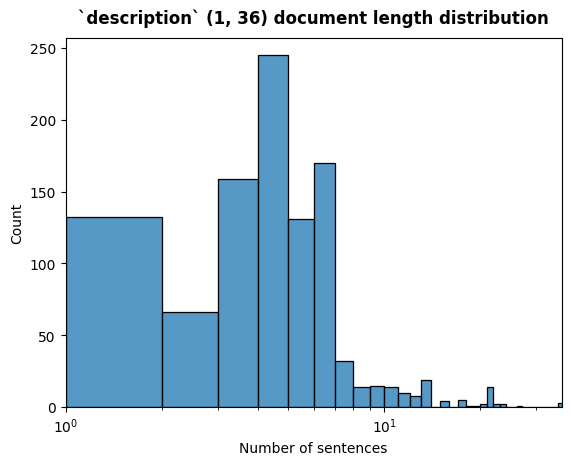

In [1]:
from flipkart_utils import get_raw_data
from tx_prep import (
    sent_tokenize_corpus,
    lens, display_lens_dist, show_lens_dist
)
corpus = get_raw_data('description')
doc_lens = lens(sent_tokenize_corpus(corpus))
display_lens_dist(doc_lens)
show_lens_dist(doc_lens, unit='sent', log_scale=(True, False))

## Décomposition en phrases

On construit une version du corpus dont l'atome est la phrase et dont chaque phrase est indexée par l'identifiant du produit auquel elle se rapporte, et sa position dans l'ensemble de phrases de la description du produit.

Le corpus des descriptions se décompose en $5\,199$ phrases.

In [2]:
from flipkart_utils import get_raw_data, full_show_sample
from tx_prep import sent_tokenize_corpus
corpus = get_raw_data('description')
sents = sent_tokenize_corpus(corpus)
full_show_sample(sents, print_func=print)

('36b965559aa2b97cb961a603f18a9183', ['Flipkart.com: Buy Fogg Dynamic,Magnetic Combo Set online only for Rs.', '360 from Flipkart.com.', 'Only Genuine Products.', '30 Day Replacement Guarantee.', 'Free Shipping.', 'Cash On Delivery!'])
('2e8df36b35d22cf219cf8bae6c2af752', ['Buy Metallino Hard Anodised Kadhai 1.2 L for Rs.588 online.', 'Metallino Hard Anodised Kadhai 1.2 L at best prices with FREE shipping & cash on delivery.', 'Only Genuine Products.', '30 Day Replacement Guarantee.'])
('c7fcd0d983a51283e58b806f065cc920', ['Buy Diviniti MDF Color Religious Wall Hanging Size 4 Radha Krishna Showpiece  -  36.4 cm for Rs.13400 online.', 'Diviniti MDF Color Religious Wall Hanging Size 4 Radha Krishna Showpiece  -  36.4 cm at best prices with FREE shipping & cash on delivery.', 'Only Genuine Products.', '30 Day Replacement Guarantee.'])
('3f9c4d0e8c3bca9c870e41f5098f90d6', ['Buy Valtellina Checkered Double Blanket Brown at Rs.', '878 at Flipkart.com.', 'Only Genuine Products.', 'Free Shippi

In [2]:
from flipkart_utils import get_raw_data
from tx_prep import ravel_corpus_sents
corpus = get_raw_data('description')
sents = ravel_corpus_sents(corpus)
display(sents)

,id,sent_id,description
0,55b85ea15a1536d46b7190ad6fff8ce7,0,Key Features of Elegance Polyester Multicolor ...
1,55b85ea15a1536d46b7190ad6fff8ce7,1,899 This curtain enhances the look of the inte...
2,55b85ea15a1536d46b7190ad6fff8ce7,2,The surreal attention is sure to steal hearts.
3,55b85ea15a1536d46b7190ad6fff8ce7,3,These contemporary eyelet and valance curtains...
4,55b85ea15a1536d46b7190ad6fff8ce7,4,Bring home the elegant curtain that softly fil...
...,...,...,...
5194,c3edc504d1b4f0ba6224fa53a43a7ad6,3,30 Day Replacement Guarantee.
5195,f2f027ad6a6df617c9f125173da71e44,0,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
5196,f2f027ad6a6df617c9f125173da71e44,1,Uberlyfe Large Vinyl Sticker at best prices wi...
5197,f2f027ad6a6df617c9f125173da71e44,2,Only Genuine Products.


## Longueur des phrases

Cette analyse permet notamment de déterminer un `clip` pertinent dans l'étape de pré-traitement.

,1,2,3,4,5,6,7,8,9,10,...,131,135,138,140,144,151,153,171,183,229
freq,2,27,271,1079,368,46,127,88,124,107,...,3,1,6,1,1,1,1,1,1,1


mean: 17.62
med : 12.00
std : 19.88


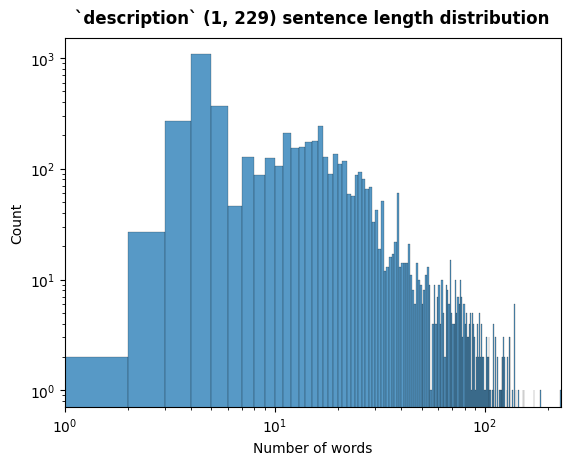

In [11]:
from flipkart_utils import get_raw_data
from tx_prep import (
    ravel_corpus_sents, word_tokenize_corpus,
    lens, display_lens_dist, show_lens_dist
)
corpus = ravel_corpus_sents(get_raw_data('description'))
sent_lens = lens(word_tokenize_corpus(corpus.description))
display_lens_dist(sent_lens)
show_lens_dist(sent_lens, unit='word', log_scale=(True, True))

Une phrase de `description` fait rarement moins de 3 mots ou plus de 30 mots.

Dans les deux cas, cela montre les limites de capacité de découpe de `sent_tokenize` sur un corpus aussi libre et peu respectueux de la ponctuation et de la syntaxe que les descriptions de produits.

In [21]:
from flipkart_utils import full_show_sample
upper_outliers = corpus[sent_lens < 3]
print("|sent| < 3", upper_outliers.description.values)

['!' '2.' '3.' '4.' '5.' '6.' '2.' '3.' '4.' '5.' '6.' '2.' '3.' '4.' '5.'
 '6.' '2.' '3.' '4.' '5.' '6.' '!!' '!' '!!' 'e.l.f.' '2.' '3.' '2.' '3.']


In [ ]:
from flipkart_utils import full_show_sample
upper_outliers = corpus[sent_lens > 30]
full_show_sample(upper_outliers.description, n=10, print_func=print)

(4949, 'Key Features of L Oreal Eversleek Sulfate - Free Smoothing System Intense Smoothing Shampoo Ideal for: Boys, Girls Skin Type: All Skin Types Form: Liquid,L Oreal Eversleek Sulfate - Free Smoothing System Intense Smoothing Shampoo (250) Price: Rs.')
(280, '1,710 Glides on smoothly and defines the look of your lips with gorgeous colour.,Specifications of Giorgio Armani SMOOTH SILK LIP PENCIL 12 (Soyeux 12) Lip Liner Details Dual-tipped No Shade Soyeux 12 Waterproof No Smudge-free No Size 1.14 In the Box 1 Lip Pencil')
(2401, 'Key Features of Hako 85W Magsafe Laptop Charger For APPLE MacBook Pro 17 MA897LLA 85 Adapter Designed For: APPLE MacBook Pro 17" MB133LL/A MAGSAFE,Hako 85W Magsafe Laptop Charger For APPLE MacBook Pro 17 MA897LLA 85 Adapter Price: Rs.')
(1478, "This dungaree set is an ideal pick for this summer and is available in multiple colors.,Specifications of Babeezworld Baby Boy's Romper Top Details Sleeve Half Sleeve Number of Contents in Sales Package Pack of 2 Fabr

## Formation du lexique

Le lexique brut des descriptions de produits comporte ($8\,166$ mots).


In [70]:
from flipkart_utils import get_raw_data
from tx_prep import ravel_corpus_sents, get_lexicon_dataframe
corpus = ravel_corpus_sents(get_raw_data('description'))
lex_data = get_lexicon_dataframe(corpus.description)
display(lex_data)

,word,freq,len
description,,,
0,Key,215,3
1,Features,337,8
2,of,1659,2
3,Elegance,7,8
4,Polyester,62,9
...,...,...,...
8161,Polyvinyl,2,9
8162,Films,2,5
8163,Imported,2,8


En première approche de découverte naïve des techniques de *sac de mots*, nous nous sommes dits que connaître les coordonnées de l'emploi de chaque mot dans le corpus pourrait avoir son utilité. L'analyse qui suit positionne $91\,613$ emplois de mots dans le corpus des descriptions produits.

Nous n'exploiterons finalement pas cette information dans la modélisation ci-après.

In [2]:
from flipkart_utils import get_raw_data
from tx_prep import ravel_corpus_sent_words
display(ravel_corpus_sent_words(get_raw_data('description')))

,id,sent_id,doc_sent_id,word_id,description
0,55b85ea15a1536d46b7190ad6fff8ce7,0,0,0,Key
1,55b85ea15a1536d46b7190ad6fff8ce7,0,0,1,Features
2,55b85ea15a1536d46b7190ad6fff8ce7,0,0,2,of
3,55b85ea15a1536d46b7190ad6fff8ce7,0,0,3,Elegance
4,55b85ea15a1536d46b7190ad6fff8ce7,0,0,4,Polyester
...,...,...,...,...,...
91608,f2f027ad6a6df617c9f125173da71e44,5198,3,0,30
91609,f2f027ad6a6df617c9f125173da71e44,5198,3,1,Day
91610,f2f027ad6a6df617c9f125173da71e44,5198,3,2,Replacement
91611,f2f027ad6a6df617c9f125173da71e44,5198,3,3,Guarantee


## Longueur et fréquence des mots

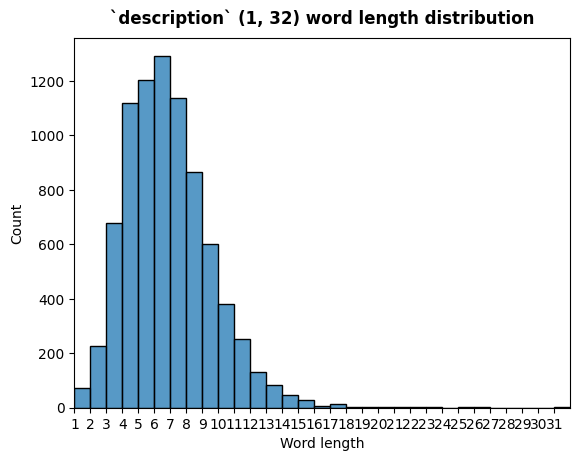

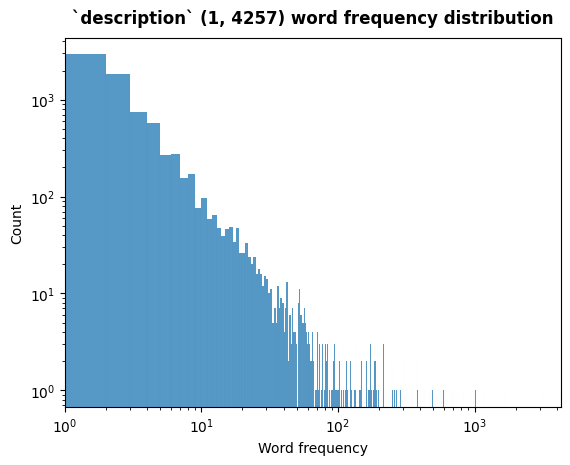

In [4]:
from tx_prep import show_lexicon_dist
show_lexicon_dist(lex_data, 'len')
show_lexicon_dist(lex_data, 'freq')

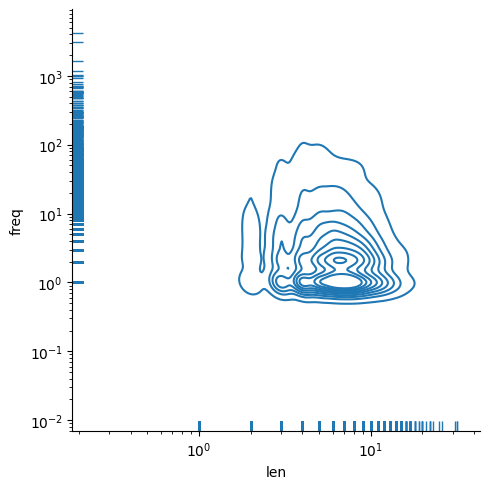

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(lex_data, x='len', y='freq', kind='kde', rug=True, log_scale=True)
plt.show()

## Cas des mots longs et des valeurs numériques

Les mots longs sont des expressions qui représentent soit des nombres, soit des nombres avec unités, soit les codes alphanumériques de références d'articles.

Dans le contexte de notre projet, ces informations ne sont pas pertinentes a priori.

Inversement, les préserver plutôt de que de les sous-décomposer introduit du *bruit* dans notre modèle, en maintenant dans le lexique des expressions non pertinentes et en invisibilisant d'éventuels mots pertinents cachés au sein de ces expressions.

Cela nous conduit au choix radical, mais assez simple à mettre en oeuvre, de supprimer toutes les expressions numériques et de séparer tous les mots composés en mots simples.

In [72]:
display(lex_data[lex_data.len > 15].head())

,word,freq,len
description,,,
252,SHUVAM20PCFTSETASSORTED,2,23
375,UFT-TSW-005-BK-BR,1,17
512,Megnet_Led_Sport_BlackRed1,3,26
571,AD1057-Dark-Orange,3,18
816,Ducjug010-ducgl012-2,4,20


## Normalisation de la casse

In [9]:
from flipkart_utils import get_raw_data
from tx_prep import get_casefolded_lexicon_dataframe
corpus = get_raw_data('description')
lex_data = get_casefolded_lexicon_dataframe(corpus)
display(lex_data)

,word,forms,freq,len
0,`,`,1,1
1,�,�,1,1
2,[,[,2,1
3,],],2,1
4,q,Q,2,1
...,...,...,...,...
6610,cotton/polyester/elastane,COTTON/POLYESTER/ELASTANE,1,25
6611,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,3,26
6612,painting_art_couple_love__dance,painting_art_couple_love__Dance,3,31
6613,dlst2020_white_tblue_navy_purple,DLST2020_WHITE_TBLUE_NAVY_PURPLE,1,32


## Stopwords

In [10]:
from tx_prep import is_stopword_en
is_stopword = is_stopword_en(lex_data.word)
print('# stopwords:', is_stopword.sum())
lex_data['is_stopword_en'] = is_stopword
display(lex_data[lex_data.is_stopword_en].tail())

# stopwords: 119


,word,forms,freq,len,is_stopword_en
4152,against,against,3,7,True
4225,because,"[Because, because]",4,7,True
4373,between,between,8,7,True
4476,through,"[Through, through]",26,7,True
5228,yourself,"[Yourself, yourself]",46,8,True


## Lemmatisation et stemmatisation

In [11]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
lex_data['stem'] = lex_data.word.apply(lambda x: stemmer.stem(x))
display(lex_data)
display(lex_data.stem.value_counts())

,word,forms,freq,len,is_stopword_en,stem
0,`,`,1,1,False,`
1,�,�,1,1,False,�
2,[,[,2,1,False,[
3,],],2,1,False,]
4,q,Q,2,1,False,q
...,...,...,...,...,...,...
6610,cotton/polyester/elastane,COTTON/POLYESTER/ELASTANE,1,25,False,cotton/polyester/elastan
6611,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,3,26,False,megnet_led_sport_blackred1
6612,painting_art_couple_love__dance,painting_art_couple_love__Dance,3,31,False,painting_art_couple_love__d
6613,dlst2020_white_tblue_navy_purple,DLST2020_WHITE_TBLUE_NAVY_PURPLE,1,32,False,dlst2020_white_tblue_navy_purpl


decor                            7
remov                            7
color                            6
function                         6
oper                             6
                                ..
vapor                            1
v220w                            1
turbo                            1
titl                             1
good-night-angel-sleep-well-p    1
Name: stem, Length: 5644, dtype: int64

In [12]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lex_data['lem'] = lex_data.word.apply(lambda x: lemmatizer.lemmatize(x))
display(lex_data)
display(lex_data.lem.value_counts())

,word,forms,freq,len,is_stopword_en,stem,lem
0,`,`,1,1,False,`,`
1,�,�,1,1,False,�,�
2,[,[,2,1,False,[,[
3,],],2,1,False,],]
4,q,Q,2,1,False,q,q
...,...,...,...,...,...,...,...
6610,cotton/polyester/elastane,COTTON/POLYESTER/ELASTANE,1,25,False,cotton/polyester/elastan,cotton/polyester/elastane
6611,megnet_led_sport_blackred1,Megnet_Led_Sport_BlackRed1,3,26,False,megnet_led_sport_blackred1,megnet_led_sport_blackred1
6612,painting_art_couple_love__dance,painting_art_couple_love__Dance,3,31,False,painting_art_couple_love__d,painting_art_couple_love__dance
6613,dlst2020_white_tblue_navy_purple,DLST2020_WHITE_TBLUE_NAVY_PURPLE,1,32,False,dlst2020_white_tblue_navy_purpl,dlst2020_white_tblue_navy_purple


leaf                                3
child                               3
polish                              3
aspect                              2
brow                                2
                                   ..
sleep                               1
shrug                               1
shine                               1
radha                               1
good-night-angel-sleep-well-pics    1
Name: lem, Length: 6205, dtype: int64

## Sémantique

Nous avons effectué quelques investigations pour capturer des caractéristiques quantitatives ou encore des références produits, mais ces données ne se sont pas révélées pertinentes dans le cadre du projet.

In [ ]:
from tx_prep import (
    is_number,
    is_number_with_unit,
    contains_digit,
    contains_number
)

words = lex_data.word
isn = words.apply(is_number)
isnu = words.apply(is_number_with_unit)
cd = words.apply(contains_digit)
cn = words.apply(contains_number)
print("number:", words[isn].values)
print("number unit:", words[isnu].values)
print("neither number not unit:", words[~(isn | isnu)].values)
print("contains digit but neither number not unit:", words[cd & ~(isn | isnu)].values)
print("contains number but neither number not unit:", words[cn & ~(isn | isnu)].values)

## Actualisation des analyses fréquentielles

Les opérations de normalisation n'affectent pas fondamentalement les profils.

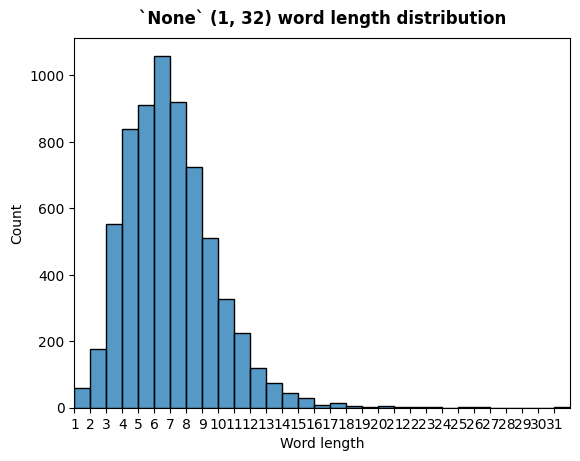

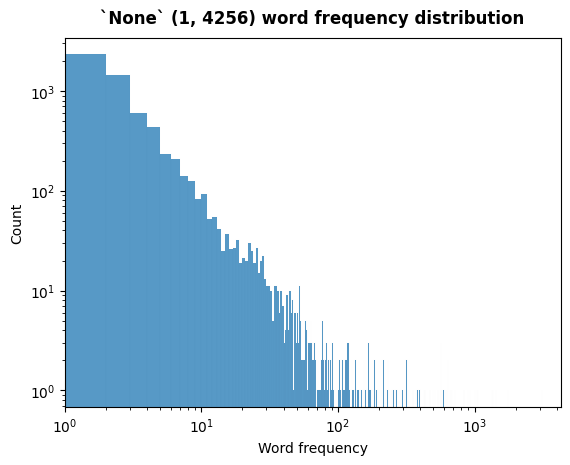

In [15]:
from tx_prep import show_lexicon_dist
show_lexicon_dist(lex_data, 'len')
show_lexicon_dist(lex_data, 'freq')

## Chaîne intégrée

Nous refaisons tout ce qui précède à l'aide d'une fonction intégrée, qui ajoute une étape amont importante décidée à partir de ce qui précède, l'élimination des références numériques et de la ponctuation.

Pour éviter de dértuire tous les mots composés, nous choisissons d'insérer cette modification de la manière suivante :
* insertion par wrapping d'une fonction clé `word_tokenize` de NLTK.
* retraitement des tous les mots contenant au moins un chiffre :
    * sous décomposition en séparant mots et chiffres
    * élimination de la ponctuation.
* retraitement des mots de plus de 15 lettres en les sous-décomposant.
* *trim* de toutes les extrémités de mots qui ne sont pas alphabétiques.

Cette fonction qui complète le travail de base de `word_tokenize` est `flipkart_word_tokenize`.

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
0,f,F,1,1,False,f,f
1,o,O,1,1,True,o,o
2,y,Y,1,1,True,y,y
3,…,…,1,1,False,…,…
4,�,�,1,1,False,�,�
...,...,...,...,...,...,...,...
5352,multifunctional,Multifunctional,3,15,False,multifunct,multifunctional
5353,anti-depressant,Anti-depressant,4,15,False,anti-depress,anti-depressant
5354,theseuberstylish,theseuberstylish,1,16,False,theseuberstylish,theseuberstylish


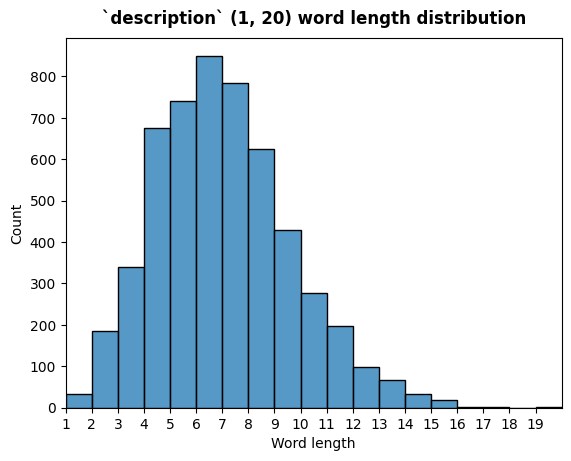

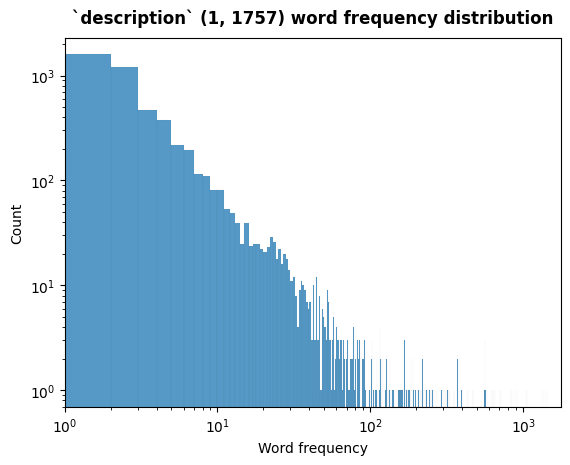

In [1]:
from flipkart_utils import get_raw_data
from tx_prep import (
    ravel_corpus_sents,
    get_flipkart_lexicon_dataframe,
    show_lexicon_dist
)
corpus = ravel_corpus_sents(get_raw_data('description'))
lex_data = get_flipkart_lexicon_dataframe(corpus.description)
display(lex_data)
show_lexicon_dist(lex_data, 'len')
show_lexicon_dist(lex_data, 'freq')

## Sauvegarde

In [2]:
from tx_prep import save_lexicon
display(lex_data)
save_lexicon(lex_data, 'description_lex')

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
0,f,F,1,1,False,f,f
1,o,O,1,1,True,o,o
2,y,Y,1,1,True,y,y
3,…,…,1,1,False,…,…
4,�,�,1,1,False,�,�
...,...,...,...,...,...,...,...
5352,multifunctional,Multifunctional,3,15,False,multifunct,multifunctional
5353,anti-depressant,Anti-depressant,4,15,False,anti-depress,anti-depressant
5354,theseuberstylish,theseuberstylish,1,16,False,theseuberstylish,theseuberstylish


# 3\. Corpus `brand`

Le plus trivial à former, il pourra avoir son utilité, notamment pour étiqueter les occurrences de la marque dans le texte des descriptions, arbre de catégories et spécifications.

Cependant, n'oublions pas que la variable `brand` souffre d'un nombre important de valeurs manquantes (31 %).

La constitution de ce corpus demande donc un travail préalable de reconstruction des données manquantes.

## Chargement des données

In [27]:
from flipkart_utils import get_raw_data
corpus = get_raw_data('brand')
display(corpus)

Flipkart
55b85ea15a1536d46b7190ad6fff8ce7                 Elegance
7b72c92c2f6c40268628ec5f14c6d590                 Sathiyas
64d5d4a258243731dc7bbb1eef49ad74                  Eurospa
d4684dcdc759dd9cdf41504698d737d8    SANTOSH ROYAL FASHION
6325b6870c54cd47be6ebfbffa620ec7             Jaipur Print
                                            ...          
958f54f4c46b53c8a0a9b8167d9140bc             Oren Empower
fd6cbcc22efb6b761bd564c28928483c               Wallmantra
5912e037d12774bb73a2048f35a00009                 Uberlyfe
c3edc504d1b4f0ba6224fa53a43a7ad6               Wallmantra
f2f027ad6a6df617c9f125173da71e44                 Uberlyfe
Name: brand, Length: 1050, dtype: object

## Longueur des documents

Cette analyse permet notamment de déterminer un `clip` pertinent dans l'étape de pré-traitement.

Une description est composée de $5$ phrases en moyenne.

,1,2,3,4,5,6
freq,456,192,60,1,2,1


mean: 1.46
med : 1.00
std : 0.70


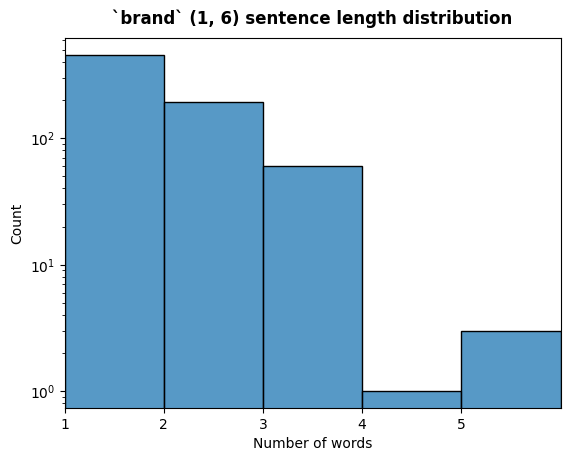

In [30]:
from flipkart_utils import get_raw_data
from tx_prep import (
    word_tokenize_corpus,
    lens, display_lens_dist, show_lens_dist
)
corpus = get_raw_data('brand').dropna()
doc_lens = lens(word_tokenize_corpus(corpus))
display_lens_dist(doc_lens)
show_lens_dist(doc_lens, unit='word', log_scale=(False, True))

## Old

In [ ]:
from flipkart_utils import get_raw_data, save_dataframe
brand = get_raw_data('brand')
brand_lex = brand.value_counts(ascending=False).reset_index()
brand_lex.columns = ['expression', 'freq']
brand_lex['casefolded_expression'] = brand_lex.expression.str.casefold()
display(brand_lex)
save_dataframe(brand_lex, 'brand')
#brand.value_counts(ascending=False).reset_index().plot()

,expression,freq,casefolded_expression
0,PRINT SHAPES,11,print shapes
1,Lapguard,11,lapguard
2,Lal Haveli,10,lal haveli
3,Raymond,8,raymond
4,Aroma Comfort,8,aroma comfort
...,...,...,...
485,Rute,1,rute
486,NAMS,1,nams
487,JewelKraft Designs,1,jewelkraft designs
488,Budding Bees,1,budding bees


# 4\. Corpus `product_category_tree`

Exploiter ce corpus ne serait pas du jeu : cela reviendrait à une fuite de données magistrale compte tenu de l'objectif du projet.

Pour l'extraction et l'explotation des catégories hiérarchisées, qui consituent la cible de prédiction, voir le notebook `cats_extract.ipynb`.

In [31]:
from flipkart_utils import get_product_category_branches
display(get_product_category_branches().head(3))

,level_0,level_1,level_2,level_3,level_4,level_5,level_6
id,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,None,None,None
7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",None,None
64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,None,None


# Scratchpad

Longueur des phrases.

Utilisation des mesures de synthèse

L'objectif est d'améliorer le score sur `description` par l'amélioration du prétraitement, et donc que comprendre ce qui fait sous-performer.

Revisualiser les données : mots de 1 lettre, etc : virer en même temps de dataxploring
Expression longues à redécouper.

références produits et autres références numériques à supprimer.

visualiser les sous-corpus et sous-vocabulaires par catégorie.

mesure TF-IDF maison à ajouter au lexique enregistré

## Prétratement du corpus

In [1]:
from flipkart_utils import get_raw_data
from tx_prep import preprocess_corpus, filter_product_descriptions
from tx_ml import get_sents_class_labels

sents, sents_index = preprocess_corpus(
    corpus=get_raw_data('description'),
    discard_words_function=filter_product_descriptions
)

In [3]:
display(sents)
display(sents_index)

0       key feature elegance polyester multicolor abst...
1       899 curtain enhances look curtain made 100 hig...
2                      surreal attention sure steal heart
3       contemporary eyelet valance curtain slide smoo...
4       bring home elegant curtain softly filter light...
                              ...                        
5194                            day replacement guarantee
5195              buy uberlyfe large vinyl sticker online
5196    uberlyfe large vinyl sticker best price free s...
5197                                      genuine product
5198                            day replacement guarantee
Name: description, Length: 5199, dtype: object

,id,sent_id
0,55b85ea15a1536d46b7190ad6fff8ce7,0
1,55b85ea15a1536d46b7190ad6fff8ce7,1
2,55b85ea15a1536d46b7190ad6fff8ce7,2
3,55b85ea15a1536d46b7190ad6fff8ce7,3
4,55b85ea15a1536d46b7190ad6fff8ce7,4
...,...,...
5194,c3edc504d1b4f0ba6224fa53a43a7ad6,3
5195,f2f027ad6a6df617c9f125173da71e44,0
5196,f2f027ad6a6df617c9f125173da71e44,1
5197,f2f027ad6a6df617c9f125173da71e44,2


## Fonction de production du lexique tout en un

L'avantage du lexique est de densifier et centraliser l'analyse des termes.

Son inconvénient est qu'il est abstrait du corpus et que les termes ne sont plus contextualisés (perte du lien avec les phrases).

NB > Besoin de TF et IDF dans le contexte des phrases + prendre le corpus prétraité en entrée (donc avec les phrases abstraites, ce qui n'est pas le cas ici, puisque )

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
0,f,F,1,1,False,f,f
1,o,O,1,1,True,o,o
2,y,Y,1,1,True,y,y
3,…,…,1,1,False,…,…
4,�,�,1,1,False,�,�
...,...,...,...,...,...,...,...
5352,multifunctional,Multifunctional,3,15,False,multifunct,multifunctional
5353,anti-depressant,Anti-depressant,4,15,False,anti-depress,anti-depressant
5354,theseuberstylish,theseuberstylish,1,16,False,theseuberstylish,theseuberstylish


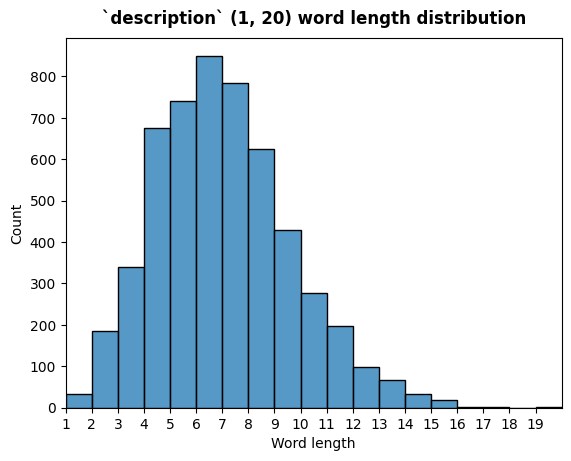

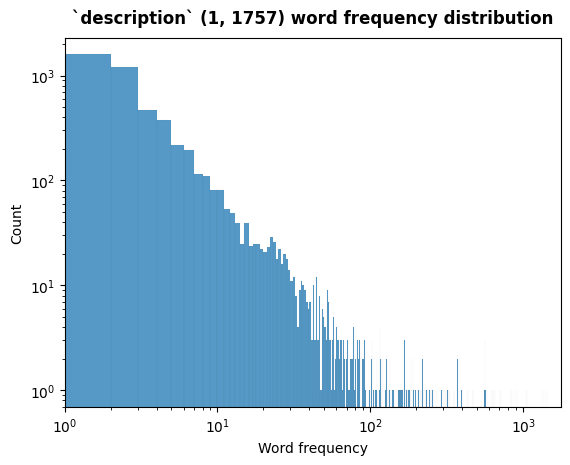

In [3]:
from flipkart_utils import get_raw_data
from tx_prep import (
    ravel_corpus_sents,
    get_flipkart_lexicon_dataframe,
    show_lexicon_dist
)
corpus = ravel_corpus_sents(get_raw_data('description'))
lex_data = get_flipkart_lexicon_dataframe(corpus.description)
display(lex_data)
show_lexicon_dist(lex_data, 'len')
show_lexicon_dist(lex_data, 'freq')

In [4]:
from tx_prep import show_n_grams
show_n_grams(lex_data, 1)

1-grams count: 32


array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', '–',
       '’', '“', '”', '•', '…', '�'], dtype=object)

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
31,a,"[A, a]",701,1,True,a,a
30,s,"[S, s]",371,1,True,s,s
29,x,"[x, X]",172,1,False,x,x
28,g,"[G, g]",125,1,False,g,g
27,l,"[l, L]",115,1,False,l,l
26,w,"[w, W]",84,1,False,w,w
25,v,"[v, V]",79,1,False,v,v
24,n,"[n, N]",70,1,False,n,n
23,e,"[e, E]",52,1,False,e,e


In [5]:
from tx_prep import show_n_grams
show_n_grams(lex_data, 2)

2-grams count: 186


array(['aa', 'ac', 'ad', 'al', 'am', 'an', 'ar', 'as', 'at', 'av', 'ax',
       'ba', 'bb', 'bd', 'be', 'bg', 'bk', 'bl', 'br', 'by', 'ca', 'cb',
       'cc', 'cd', 'ce', 'cl', 'cm', 'co', 'cp', 'cq', 'cr', 'ct', 'db',
       'de', 'dg', 'do', 'dv', 'dw', 'ea', 'ed', 'ei', 'el', 'eo', 'eu',
       'ez', 'fb', 'fd', 'fh', 'fk', 'fs', 'ft', 'fu', 'gb', 'gc', 'gm',
       'go', 'gr', 'gw', 'ha', 'hd', 'he', 'hf', 'hg', 'hn', 'hp', 'hz',
       'ic', 'id', 'if', 'ig', 'ii', 'in', 'ip', 'is', 'it', 'iw', 'ja',
       'jm', 'kd', 'ke', 'kg', 'ki', 'kv', 'la', 'll', 'lm', 'lp', 'ls',
       'lx', 'ma', 'mb', 'md', 'me', 'mh', 'ml', 'mm', 'mn', 'mp', 'ms',
       'mx', 'my', 'na', 'nc', 'nd', 'nk', 'no', 'nr', 'nt', 'nw', 'nx',
       'of', 'on', 'or', 'os', 'oz', 'pa', 'pc', 'pg', 'pk', 'pl', 'pp',
       'pu', 'qp', 'rd', 're', 'rg', 'ri', 'rk', 'ro', 'rp', 'rs', 'rt',
       'sd', 'se', 'sf', 'sg', 'sj', 'sl', 'sm', 'so', 'ss', 'st', 'su',
       'sw', 'ta', 'tb', 'tc', 'td', 'te', 'tg', 't

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
217,of,"[OF, Of, of]",1757,2,True,of,of
216,to,"[TO, To, to]",1053,2,True,to,to
215,in,"[IN, In, in]",1047,2,True,in,in
214,rs,Rs,911,2,False,rs,r
213,on,"[ON, on, On]",832,2,True,on,on
...,...,...,...,...,...,...,...
59,nw,NW,1,2,False,nw,nw
58,nt,NT,1,2,False,nt,nt
57,nr,nr,1,2,False,nr,nr


In [6]:
from tx_prep import show_n_grams
show_n_grams(lex_data, 3)

3-grams count: 341


array(['a/c', 'aaa', 'aci', 'acl', 'act', 'add', 'adf', 'adi', 'age',
       'air', 'all', 'and', 'ant', 'any', 'app', 'arb', 'are', 'art',
       'ash', 'ast', 'atm', 'avi', 'bad', 'bag', 'bar', 'bed', 'bft',
       'bib', 'big', 'bio', 'bit', 'blk', 'bls', 'blu', 'bmp', 'bmw',
       'bos', 'bow', 'box', 'boy', 'bpa', 'bsf', 'btp', 'bts', 'but',
       'buy', 'cal', 'can', 'cap', 'car', 'cau', 'cmr', 'cms', 'cmw',
       'cmx', 'cnl', 'cow', 'cpu', 'ctw', 'cup', 'cut', 'dad', 'dap',
       'dat', 'day', 'ddr', 'deo', 'dia', 'did', 'dir', 'dmk', 'don',
       'dos', 'dra', 'dru', 'dry', 'dsl', 'due', 'duo', 'dvd', 'eat',
       'ebw', 'ech', 'edp', 'elf', 'end', 'era', 'etc', 'eva', 'eye',
       'fab', 'fan', 'fat', 'fcc', 'few', 'fit', 'flu', 'flv', 'fly',
       'for', 'fsp', 'fun', 'fur', 'gas', 'gel', 'gen', 'get', 'ghz',
       'gid', 'glb', 'gld', 'gms', 'god', 'got', 'grn', 'gsm', 'gtw',
       'gum', 'gym', 'had', 'has', 'hat', 'hem', 'her', 'him', 'hip',
       'his', 'hit',

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
558,for,"[FOR, For, for]",1436,3,True,for,for
557,the,"[THE, The, the]",1363,3,True,the,the
556,and,"[AND, And, and]",1332,3,True,and,and
555,buy,"[buy, Buy]",581,3,False,buy,buy
554,day,"[day, Day]",539,3,False,day,day
...,...,...,...,...,...,...,...
279,rce,RCE,1,3,False,rce,rce
280,rib,rib,1,3,False,rib,rib
281,rid,rid,1,3,False,rid,rid


In [7]:
from tx_prep import show_n_grams
show_n_grams(lex_data, 4)

4-grams count: 675


array(['aari', 'abkl', 'able', 'acer', 'acid', 'acne', 'acts', 'adaa',
       'adds', 'adsl', 'aero', 'ages', 'aids', 'akup', 'aleo', 'ally',
       'aloe', 'also', 'amit', 'amps', 'anna', 'anti', 'apex', 'arch',
       'area', 'arts', 'asia', 'asus', 'aura', 'auto', 'away', 'azan',
       'baba', 'baby', 'back', 'bags', 'bain', 'ball', 'balm', 'band',
       'bank', 'bapa', 'base', 'bath', 'bdoa', 'bean', 'bear', 'beat',
       'beds', 'been', 'beer', 'bees', 'bela', 'bell', 'belt', 'best',
       'bird', 'bits', 'blow', 'blue', 'bmli', 'bmly', 'bnsi', 'bobs',
       'body', 'bold', 'bone', 'bong', 'book', 'born', 'both', 'bowl',
       'boys', 'brow', 'btsc', 'bulb', 'bull', 'bump', 'burn', 'burp',
       'burt', 'buzz', 'calf', 'call', 'caps', 'card', 'care', 'cart',
       'casa', 'case', 'cash', 'cast', 'cats', 'cell', 'cfsl', 'chat',
       'chef', 'chic', 'city', 'claw', 'clay', 'clip', 'club', 'cmgy',
       'cmly', 'code', 'coin', 'cokb', 'cold', 'come', 'cook', 'cool',
      

,word,forms,freq,len,is_stopword_en,stem,lem
description,,,,,,,
1233,only,"[ONLY, only, Only]",890,4,True,onli,only
1232,with,"[WITH, With, with]",842,4,True,with,with
1231,your,"[YOUR, Your, your]",656,4,True,your,your
1230,free,"[free, FREE, Free]",614,4,False,free,free
1229,cash,"[cash, Cash]",564,4,False,cash,cash
...,...,...,...,...,...,...,...
663,ribs,ribs,1,4,False,rib,rib
662,rava,rava,1,4,False,rava,rava
661,rani,RANI,1,4,False,rani,rani
